<div style="width:100%;text-align: center;"> <img align=middle src="https://media.wired.com/photos/5926583dcfe0d93c4742fde3/master/w_2560%2Cc_limit/Alzheimers_TA.gif" alt="Heat beating" style="height:366px;margin-top:3rem;"> </div>

# <span style='color:aliceblue'><center style='background:#002E94;border-radius:0px 25px;padding:25px'> 🧠Alzheimer Classification with MRI Images </center></span>

# **<span style="color:#FF731D;">📰About the Dataset</span>**

A progressive disease that destroys memory and other important mental functions.
Brain cell connections and the cells themselves degenerate and die, eventually destroying memory and other important mental functions.

Memory loss and confusion are the main symptoms.
No cure exists, but medication and management strategies may temporarily improve symptoms.

The data consists of MRI images. The data has four classes of images both in training as well as a testing set:

> Mild Demented

> Moderate Demented

> Non Demented

> Very Mild Demented

In [2]:
#Environment check
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

2022-10-11 11:57:54.704355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **<span style="color:#FF731D;">📰Get Data </span>**

In [4]:
data = "input/AugmentedAlzheimerDataset"

In [5]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(data).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

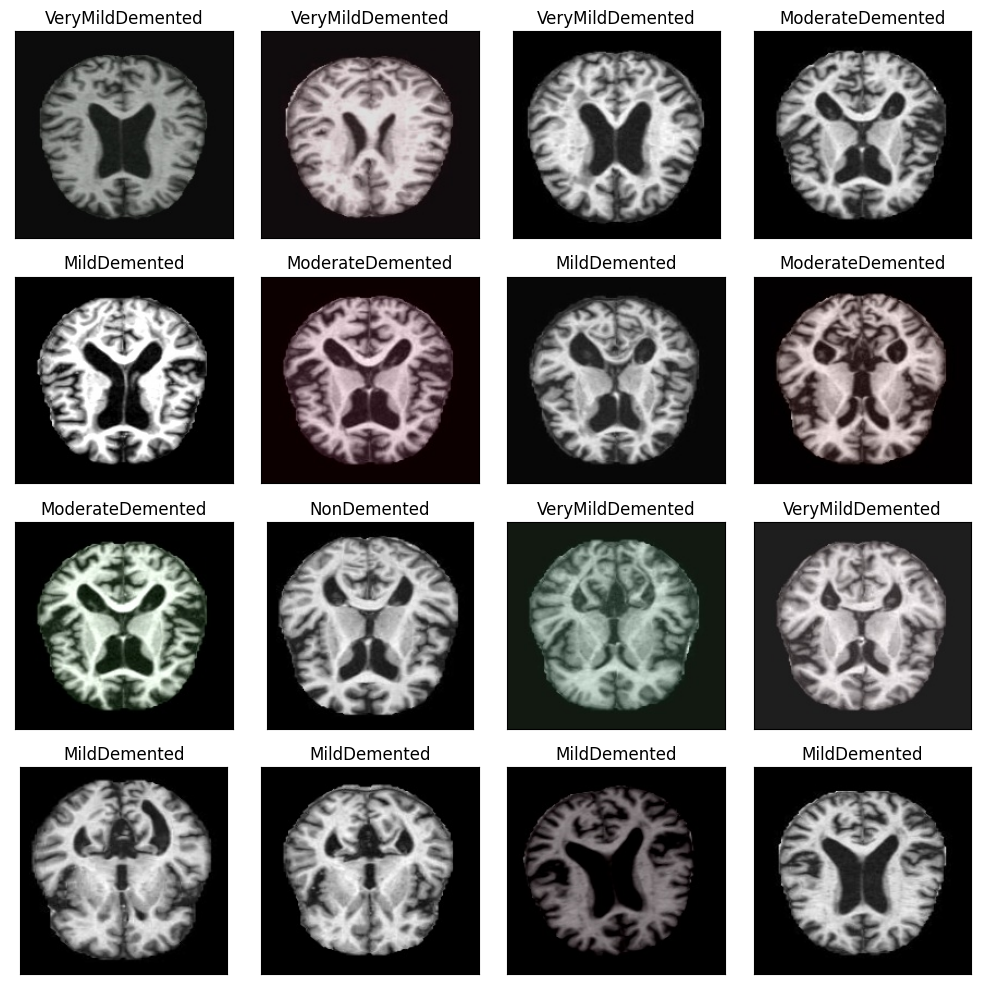

In [7]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)  # set validation split


In [9]:
train_images = train_datagen.flow_from_directory(
    data,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)  # set as training data

validation_images = train_datagen.flow_from_directory(
    data,  # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)  # set as validation data


Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [10]:
train_images.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [11]:
validation_images.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

# **<span style="color:#FF731D;">🌟Let's try CNN Model</span>**

In [12]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])



2022-10-11 11:58:16.264605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10
)

Epoch 1/10
 60/850 [=>............................] - ETA: 5:27 - loss: 1.3735 - accuracy: 0.2922

In [ ]:
model.save(os.path.join('models','m1.h5'))

***Model is overfitting***

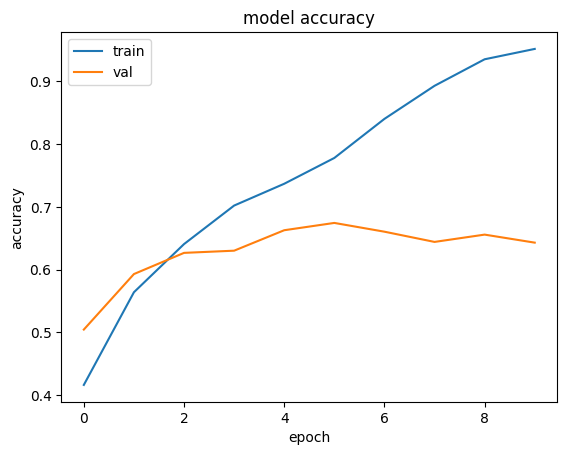

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

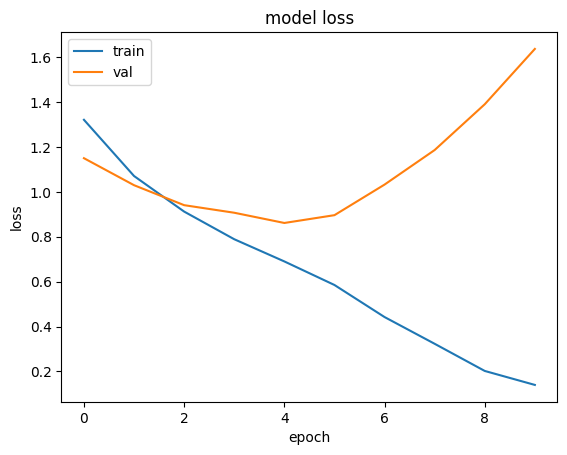

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **<span style="color:#FF731D;">🌟Let's try Inception Model (Transfer Learning)</span>**

In [ ]:
inception_model = Sequential()

pretrained_model = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=4,
    weights='imagenet',
)
for layer in pretrained_model.layers:
    layer.trainable = False

inception_model.add(pretrained_model)


In [ ]:
inception_model.add(Flatten())
inception_model.add(Dense(512, activation='relu'))
inception_model.add(Dropout(0.2))
inception_model.add(Dense(4, activation='softmax'))

In [ ]:
inception_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 22,854,437
Trainable params: 1,051,653
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inception_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history = inception_model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=10
)


Epoch 1/10
109/109 [==============================] - 87s 717ms/step - loss: 0.7636 - accuracy: 0.7405 - val_loss: 0.5306 - val_accuracy: 0.8116
Epoch 2/10
109/109 [==============================] - 80s 737ms/step - loss: 0.3959 - accuracy: 0.8583 - val_loss: 0.4296 - val_accuracy: 0.8442
Epoch 3/10
109/109 [==============================] - 81s 744ms/step - loss: 0.3481 - accuracy: 0.8713 - val_loss: 0.7188 - val_accuracy: 0.7453
Epoch 4/10
109/109 [==============================] - 78s 720ms/step - loss: 0.2903 - accuracy: 0.8901 - val_loss: 0.4481 - val_accuracy: 0.8430
Epoch 5/10
109/109 [==============================] - 80s 733ms/step - loss: 0.2237 - accuracy: 0.9199 - val_loss: 0.4162 - val_accuracy: 0.8570
Epoch 6/10
109/109 [==============================] - 79s 724ms/step - loss: 0.1965 - accuracy: 0.9286 - val_loss: 0.5797 - val_accuracy: 0.8198
Epoch 7/10
109/109 [==============================] - 82s 751ms/step - loss: 0.1682 - accuracy: 0.9375 - val_loss: 0.4606 - val_ac

In [ ]:
inception_model.save(os.path.join('models','m2.h5'))

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


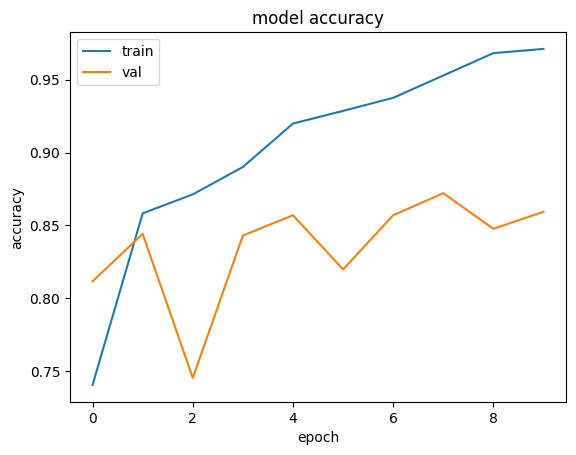

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

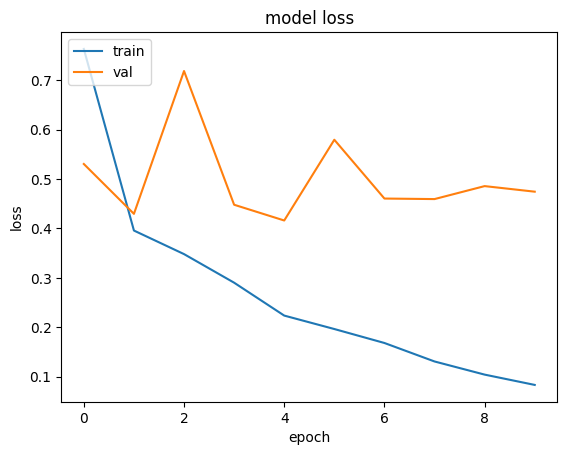

In [ ]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **<span style="color:#DA291C;">🤘Conclusion</span>**

> **This marks the end of 🧠Alzheimer Classification with MRI Images**

> **Stay Tuned for more..**

> **Please share your feedback and suggestions and help me improve 😇**